# NBV Inference

In this notebook, I will read a stored 3D grid and will compute the NBV using an already trained NBV-net. This could be used "out of the box" for NBV planning or making a comparison against NBV planning methods. As example, some grids are provided in the data folder.

@juan1rving

## Definitions and utility functions



In [1]:
# First several parameters should be defined

# txt file that contains all occupancy probabilities for the 32x32x32 voxels
octomap_file = './data/bunny_octree_1.txt'
# The txt file will be converted to a numpy file
octomap_numpy_file = './log/octomap.npy'
# specify the voxel spatial resolution
voxel_resolution = 0.025
# dropout is only used for training
dropout = 0.2

In [2]:
import numpy as np
import time
from datetime import datetime

import regression_nbv_utils as rnbv

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#import torch.nn as nn
#from torch import optim
#import torch.nn.functional as F

from torch.autograd import Variable

import nbvnet

In [3]:
#check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)


cpu


In [4]:
# Display variables
scan_locations = []
init_location = np.array([1.0, 0, 0.3, 0, 0, 3.1416])
scan_locations.append(init_location)

In [5]:
# Reads a txt file and returns a 3D grid
def readTxtOctomapAsCube(octomap_file, voxel_resolution, map_shape = [32, 32, 32]):
    # contains the octree encoded as a 1D array
    raw_data = np.loadtxt(octomap_file, dtype = float)
    
    pmin = np.array([np.min(raw_data[:,0]), np.min(raw_data[:,1]), np.min(raw_data[:,2])])
    
    positions = raw_data[:,0:3]
    occupancy = raw_data[:,3]

    if (len(occupancy) != map_shape[0]*map_shape[1]*map_shape[2]):
        print("WARNING:", len(occupancy)," readed elements.", map_shape[0]*map_shape[1]*map_shape[2], " expected")
    
    idx = positions[:,0] - pmin[0]
    idx = idx / voxel_resolution
    idx = idx.astype(np.float32)
    idx = idx.astype(np.int32)

    idy = positions[:,1] - pmin[1]
    idy = idy / voxel_resolution
    idy = idy.astype(np.float32)
    idy = idy.astype(np.int32)

    idz = positions[:,2] - pmin[2]
    idz = idz / voxel_resolution
    idz = idz.astype(np.float32)
    idz = idz.astype(np.int32)

    output_cube = np.zeros([32,32,32])
    #print(output_cube.shape)

    for i, p in enumerate(occupancy):
        output_cube[idx[i],idy[i],idz[i]] = p
        
    return output_cube

## Build NBV-net



In [6]:
net = nbvnet.NBV_Net(dropout)

net.to(device)

## print out your net and prepare it for testing (uncomment the line below)
print(net)
net.eval()

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.2, inplace=False)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=1500, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  

NBV_Net(
  (conv1): Conv3d(1, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(10, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(12, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_drop): Dropout(p=0.2, inplace=False)
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=1500, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc3_drop): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  

In [7]:
# Load weights 
# The parameters of NBV-net for classification were saved with
#torch.save(net.state_dict(), saving_weights_file)

reading_weights_file = './data/weights.pth'

# Whether you are loading from a partial state_dict, which is missing some keys, 
# or loading a state_dict with more keys than the model that you are loading into,
# you can set the strict argument to False in the load_state_dict() function to ignore non-matching keys.

net.load_state_dict(torch.load(reading_weights_file, map_location='cpu'), strict=False)

<All keys matched successfully>

In [8]:
# Read the pose that corresponds to a class.
# such poses are the vertices of an icosahedron
nbv_positions = np.genfromtxt('./points_in_sphere.txt')

# This function converts a class to its corresponding pose
def getPositions(nbv_class, positions):
    return np.array(positions[nbv_class])

## Read current octree

Reading: ./data/bunny_octree_1.txt
(32, 32, 32)


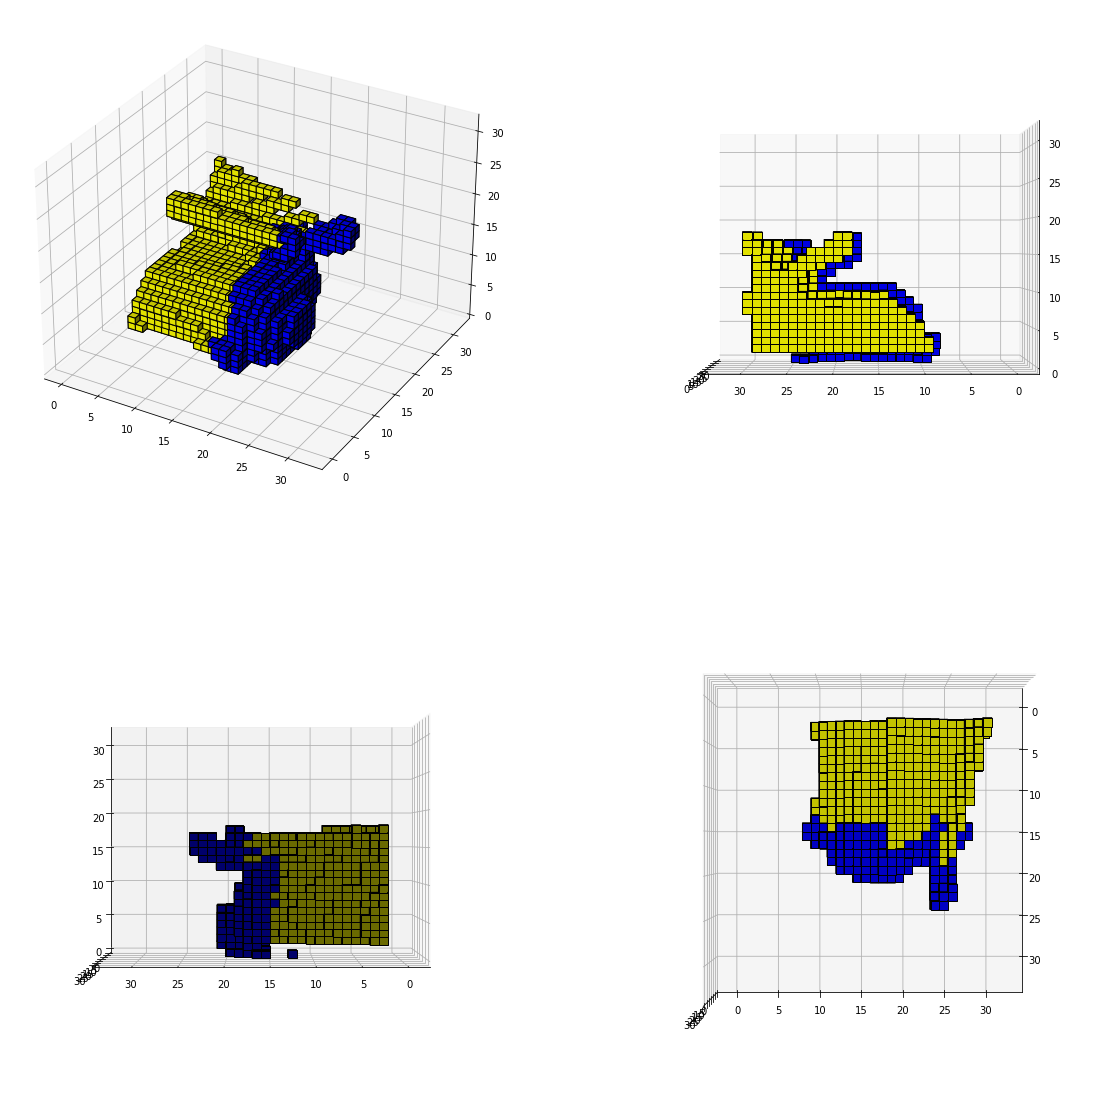

In [9]:
# Read octree
cube = readTxtOctomapAsCube(octomap_file, voxel_resolution, map_shape = [32, 32, 32])
print("Reading: " + octomap_file)
object_name = 'mask'

# save for log
np.save(octomap_numpy_file, cube)
#cube = np.load(octomap_numpy_file)

print(cube.shape)
rnbv.showGrid4(cube, np.array([0,0,0]))

## Fordward pass


In [10]:
# Forward pass

# get sample data: images and ground truth keypoints
grids = torch.from_numpy(np.array([[cube]]))
print(grids.size())
grids = grids.type(torch.FloatTensor)
        
# wrap them in a torch Variable
grids = Variable(grids)    
grids = grids.to(device)

# forward pass to get net output
start = time.time()
output = net.forward(grids)
end = time.time()

print("processing time:", end-start)

grids = grids.cpu()
output = output.cpu()
output = output.detach().numpy()
output = output.squeeze()

print(output)

class_nbv = np.where(output == np.amax(output))
print(class_nbv)

torch.Size([1, 1, 32, 32, 32])
processing time: 0.003991127014160156
[1.3940929e-13 1.3940929e-13 1.5074948e-09 1.0000000e+00 1.3940929e-13
 1.3940929e-13 1.3940929e-13 1.3940929e-13 1.3940929e-13 1.3940929e-13
 1.3940929e-13 1.3940929e-13 1.3940929e-13 1.3940929e-13]
(array([3], dtype=int64),)


[-0.3945425 -0.64949    0.65     ]


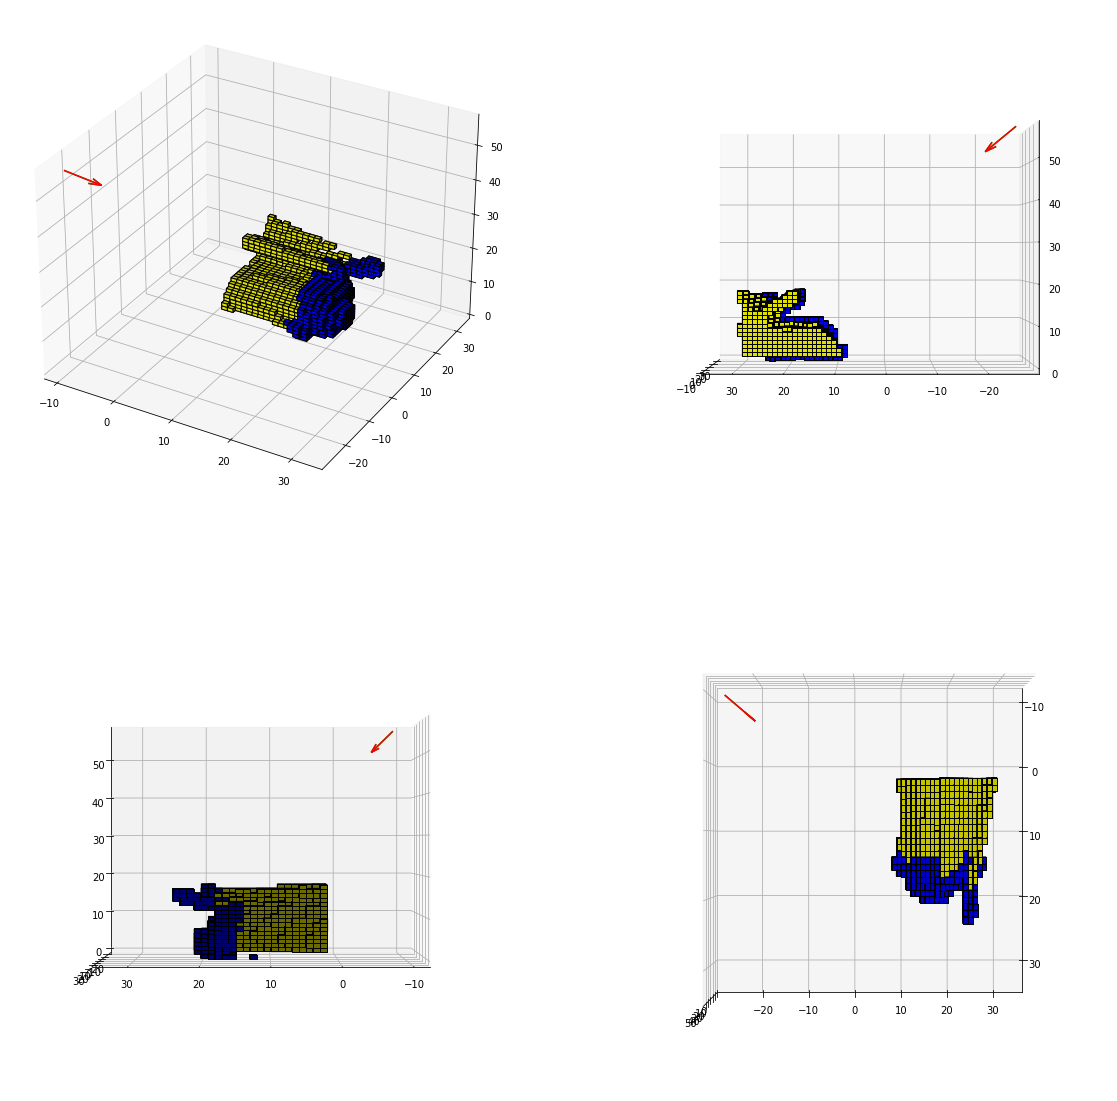

In [11]:
# get the pose from the class
bar_nbv = getPositions(class_nbv, nbv_positions) 
nbv_scale = 2.5
bar_nbv  = nbv_scale * bar_nbv
bar_nbv = bar_nbv.squeeze()
print(bar_nbv)

rnbv.showGrid4(cube, bar_nbv, bar_nbv)

In [12]:
# compute  orientation
origin = np.array([0,0,0])
r = origin - bar_nbv 

# covert r to unitary vector
norm = np.linalg.norm(r)
r = (1/norm) * r
print(r)

[ 0.39454229  0.64948966 -0.64999966]


In [13]:
yaw = np.arctan2(r[1], r[0])
pitch = - np.arcsin(r[2])
roll = 0;

full_nbv = np.array([bar_nbv[0], bar_nbv[1], bar_nbv[2], yaw, pitch, roll])
full_nbv_deg = np.array([bar_nbv[0], bar_nbv[1], bar_nbv[2], yaw * 180/np.pi, pitch * 180/np.pi, roll* 180/np.pi])
print('full NBV:',full_nbv)
print('full NBV degress:', full_nbv_deg)

full NBV: [-0.3945425  -0.64949     0.65        1.02490586  0.70758399  0.        ]
full NBV degress: [-0.3945425  -0.64949     0.65       58.72278042 40.54157628  0.        ]


In [14]:
# save nbv
np.savetxt('./log/nbv.txt', full_nbv)